## Bibliotecas

In [ ]:
!pip install deepxde

import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json
import random
import seaborn as sns
import csv
import pickle

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.1 MB/s eta 0:00:00


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



## Problema Inverso

In [ ]:
# importar os potenciais elétricos dos experimentos salvos
with open(caminho, 'rb') as arquivo:
    experimentos = pickle.load(arquivo)

experimentos = [float(item) for sublist in experimentos for item in sublist]
experimentos = [experimentos[i:i+32] for i in range(0, len(experimentos), 32)]

In [ ]:
# equação diferencial
def pde(u, q):
  phi, sigma = q[:,0:1], q[:,1:2]
  gradient_x = sigma*dde.grad.jacobian(phi, u, i=0, j=0)
  gradient_y = sigma*dde.grad.jacobian(phi, u, i=0, j=1)
  divergent = dde.grad.jacobian(gradient_x, u, i=0, j=0) + dde.grad.jacobian(gradient_y, u, i=0, j=1)
  return divergent

# calcula o vetor normal a um ponto da circunferência
def outer_normal_vector(u):
  x_component = u[:,0:1]/((u[:,0:1]**2+u[:,1:2]**2)**(1/2))
  y_component = u[:,1:2]/((u[:,0:1]**2+u[:,1:2]**2)**(1/2))
  return [x_component, y_component]

# bc nos eletrodos de entrada
def fct_entry_eletrode(u, q, _):
  J = 190*1e-3
  # eletrodo de entrada
  current = J
  # eletrodo de saída
  phi, sigma = q[:,0:1], q[:,1:2]
  # sigma x derivada direcional - J
  outer_vec_entry = outer_normal_vector(u)
  # sigma x derivada direcional - J
  ans = sigma*(dde.grad.jacobian(phi, u, i=0, j=0)*outer_vec_entry[0] + dde.grad.jacobian(phi, u, i=0, j=1)*outer_vec_entry[1]) - current
  return ans

# bc nos eletrodos de saída
def fct_exit_eletrode(u, q, _):
  J = 190*1e-3
  # eletrodo de entrada
  current = -J
  # eletrodo de saída
  phi, sigma = q[:,0:1], q[:,1:2]
  # sigma x derivada direcional - J
  outer_vec_entry = outer_normal_vector(u)
  # sigma x derivada direcional - J
  ans = sigma*(dde.grad.jacobian(phi, u, i=0, j=0)*outer_vec_entry[0] + dde.grad.jacobian(phi, u, i=0, j=1)*outer_vec_entry[1]) - current
  return ans

# bc nos outros eletrodos
def fct_other_eletrodes(u, q, _):
  J = 0
  # eletrodo de entrada
  current = 0
  # eletrodo de saída
  phi, sigma = q[:,0:1], q[:,1:2]
  # sigma x derivada direcional - J
  outer_vec_entry = outer_normal_vector(u)
  # sigma x derivada direcional - J
  ans = sigma*(dde.grad.jacobian(phi, u, i=0, j=0)*outer_vec_entry[0] + dde.grad.jacobian(phi, u, i=0, j=1)*outer_vec_entry[1]) - current
  return ans

# bc fora dos eletrodos
def fct_not_eletrode(u, q, _):
  J = 0
  # eletrodo de entrada
  current = 0
  # eletrodo de saída
  phi, sigma = q[:,0:1], q[:,1:2]
  # sigma x derivada direcional - J
  outer_vec_entry = [0,0]
  # sigma x derivada direcional - J
  ans = sigma*(dde.grad.jacobian(phi, u, i=0, j=0)*outer_vec_entry[0] + dde.grad.jacobian(phi, u, i=0, j=1)*outer_vec_entry[1]) - current
  return ans

# identifica o eletrodo de entrada
def entry_eletrode(x, on_boundary):
  global entry_eletrode_values
  return on_boundary and np.allclose(x, entry_eletrode_values)

# identifica o eletrodo de saída
def exit_eletrode(x, on_boundary):
  global exit_eletrode_values
  return on_boundary and np.allclose(x, exit_eletrode_values)

# identifica se o eletrodo não é de entrada nem de saída
def other_eletrodes(x, on_boundary):
  global entry_eletrode_values, exit_eletrode_values, eletrodes
  return on_boundary and not(np.allclose(x, entry_eletrode_values) or np.allclose(x, exit_eletrode_values)) and is_eletrode(x)

# não é eletrodo
def not_eletrode(x, on_boundary):
  return on_boundary and not is_eletrode(x)

# verifica se é eletrodo
def is_eletrode(x):
  global eletrodes
  for eletrode in eletrodes:
    if np.allclose(x, eletrode):
      return True
  return False

# transforma a condutividade elétrica na saída da rede neural em um número positivo
def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]

    return tf.concat(
        [y1, y2 * y2], axis=1
    )

In [ ]:
# plota o potencial elétrico nos eletrodos
def plot_pot(model, eletrodes, i):
  pot = model.predict(eletrodes)[:,0:1]
  x = np.arange(0,32,1)
  index_entry_eletrode = i
  index_exit_eletrode = index_entry_eletrode + 4
  y = [1e+3*float(item) for item in pot]
  plt.figure()
  plt.plot(x, y)
  plt.scatter(index_entry_eletrode, y[index_entry_eletrode], c='green', s=100, label = 'eletrodo de entrada')
  plt.scatter(index_exit_eletrode, y[index_exit_eletrode], c='red', s=100, label = 'eletrodo de saída')
  plt.xlabel("Eletrodo")
  plt.ylabel("Potencial (mV)")
  plt.title('Potencial elétrico nos eletrodos')
  plt.legend()
  plt.show()
  plt.close()

# plota a condutividade
def plot_cond(model, x):
  yhat = model.predict(x)
  uhat, qhat = yhat[:, 0:1], yhat[:, 1:2]
  qhat = [float(i) for i in qhat]
  g = sns.scatterplot(x=[float(i) for i in x[:,0:1]], y=[float(i) for i in x[:,1:2]], hue=qhat, size=0.1, palette='rocket')
  g.legend(title='Condutividade prevista', loc='upper right')
  g.set(xlabel='Coordenada x', ylabel='Coordenada y')
  plt.show()

# calcula a distância entre dois pontos
def distance(p1, p2):
  return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

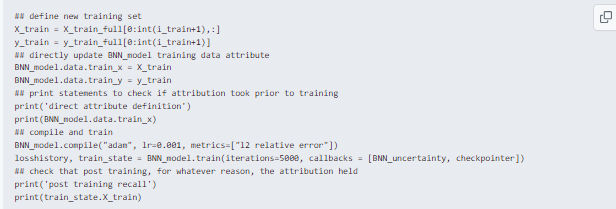

In [ ]:
pred = []

# criando a geometria: uma circunferência
geom = dde.geometry.Disk([0,0], 0.15)

# criando os eletrodos
eletrodes = geom.uniform_boundary_points(32)

x = geom.random_points(10000)

for i in range(len(experimentos)):

  index_entry_eletrode = i
  entry_eletrode_values = eletrodes[index_entry_eletrode]
  entry_eletrode_values = np.array([entry_eletrode_values])[0]

  # eletrodo de saída
  index_exit_eletrode = index_entry_eletrode + 4 if index_entry_eletrode + 4 < np.shape(eletrodes)[0] else index_entry_eletrode + 4 - np.shape(eletrodes)[0]
  exit_eletrode_values = eletrodes[index_exit_eletrode]
  exit_eletrode_values = np.array([exit_eletrode_values])[0]

  experimentos_zero = np.subtract(experimentos[i], experimentos[i][0])

  # observe_potential precisa ser alterado
  observe_potential = dde.icbc.PointSetBC(eletrodes, experimentos_zero, component=0)

  # condição de contorno
  bc_entry_eletrode = dde.OperatorBC(geom, fct_entry_eletrode, entry_eletrode)
  bc_exit_eletrode = dde.OperatorBC(geom, fct_exit_eletrode, exit_eletrode)
  bc_other_eletrodes = dde.OperatorBC(geom, fct_other_eletrodes, other_eletrodes)
  bc_not_eletrodes = dde.OperatorBC(geom, fct_not_eletrode, not_eletrode)

  loss_weights = [10, 250, 250, 250, 250, 250]

  # criando o conjunto de dados
  data = dde.data.PDE(geom, pde, [bc_entry_eletrode, bc_exit_eletrode, bc_other_eletrodes, bc_not_eletrodes, observe_potential], num_domain=700, num_boundary=200, anchors=eletrodes, num_test=100)

  # criando a rede
  net = dde.nn.PFNN([2] + [40, 40]*5 + [2], "tanh", "Glorot uniform")
  net.apply_output_transform(output_transform)

  # compilando o modelo
  model = dde.Model(data, net)

  model.compile(optimizer='adam', lr=0.001, loss_weights = loss_weights)

  checkpointer = dde.callbacks.ModelCheckpoint("model/model", verbose=1, save_better_only=True)
  losshistory, train_state = model.train(iterations=20000, display_every=10000, callbacks=[checkpointer])

  pred.append(model.predict(x)[:,1:2])

  plot_cond(model, x)

0
Compiling model...
Building feed-forward neural network...
'build' took 0.146753 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 6.224825 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.27e-04, 9.00e+00, 9.09e+00, 3.46e-05, 0.00e+00, 2.54e-01]    [1.84e-04, 9.00e+00, 9.09e+00, 3.46e-05, 0.00e+00, 2.54e-01]    []  
Epoch 1: train loss improved from inf to 1.83e+01, saving model to model/model-1.ckpt ...



KeyboardInterrupt: ignored

In [ ]:
caminho_pred = 'caminho_salvar_previsoes'

# Salvar a lista no arquivo
with open(caminho_pred, 'wb') as arquivo:
    pickle.dump(pred, arquivo)

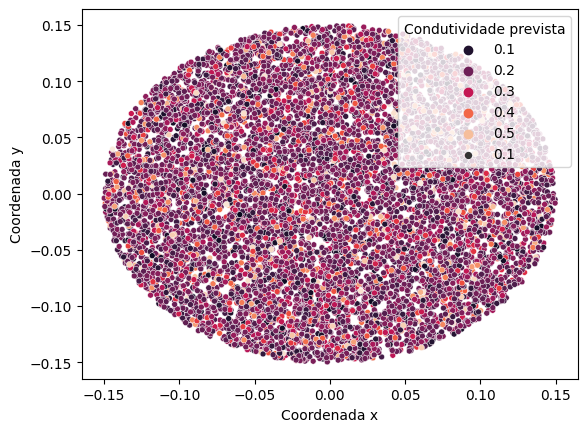

In [ ]:
index_entry = 1
index_exit = index_entry + 4
qhat = [float(i) for i in pred[index_entry]]
g = sns.scatterplot(x=[float(i) for i in x[:,0:1]], y=[float(i) for i in x[:,1:2]], hue=qhat, size=0.1, palette='rocket')
g.legend(title='Condutividade prevista', loc='upper right')
g.set(xlabel='Coordenada x', ylabel='Coordenada y')
plt.show()

[Text(0.5, 0, 'Coordenada x'), Text(0, 0.5, 'Coordenada y')]

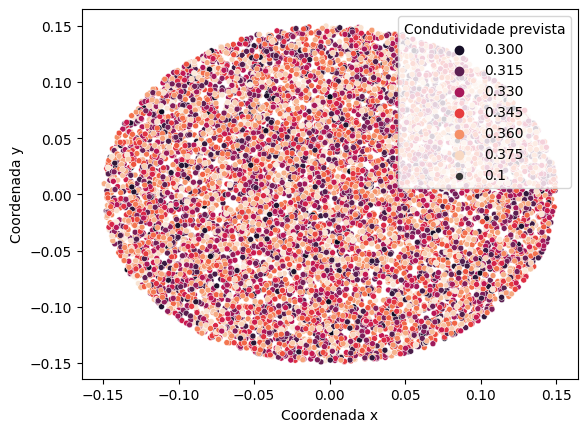

In [ ]:
w_mean = []

geom = dde.geometry.Disk([0,0], 0.15)
eletrodes = geom.uniform_boundary_points(32)
x = geom.random_points(10000)

x_i=[float(i) for i in x[:,0:1]]
y_i=[float(i) for i in x[:,1:2]]
l2 = 0

for i in range(len(x[:,0:1])):
  sum_w = 0
  sum_cond = 0
  for j in range(1,len(pred)):
    dist = distance(eletrodes[j], x[i])
    w = 1
    sum_w += w
    try:
      sum_cond += w*pred[j][i]
    except:
      print(i, j)
  mean = float(sum_cond/sum_w)
  l2 += (mean - 0.3815)**2
  w_mean.append(mean)

l2 = l2/len(x)